
## Histopathologic Cancer Detection
Identify metastatic tissue in histopathologic scans of lymph node sections <br>
By Nathan Hutchins

### Description
In this project we are challenged to identify metastatic cancer in small image patches taken from larger digital pathology scans. Simply put, we are given 96 by 96 digital histopathologic images that we need to determine cancerous or non-cancerous. With this information we can tell that this problem is a __Binary Classification__ problem.

### Data Analysis
- The data consists of 96x96 scans (images)
- A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. 
   - Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.
- Kaggle mentiones that the original data set contains duplicates, but "the version presented on Kaggle does not contain duplicates."
- There are only two images that I could find that needed to be removed. One was a fully black image which would've caused incorrect results. The other was causing errors with models created later in the project. (both these images will be shown and removed below)

__So the first two things I would like to check for are:__
1. Are there any NULL or empty rows in the two given csvs
2. Is the training data label distribution an even split. We don't want the data to be favorable to one side (unbalanced).

In [7]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle

In [8]:
# Read in labels and sample submissions
labels =  pd.read_csv('./data/train_labels.csv')
sample_submissions = pd.read_csv('./data/sample_submission.csv')

# Check if either have a null entry (probably don't need to do this for sample. But better safe than sorry)
print(f"Train Labels:\n{labels.isnull().sum()}\n====")
print(f"Sample Submissions:\n{sample_submissions.isnull().sum()}\n====")


Train Labels:
id       0
label    0
dtype: int64
====
Sample Submissions:
id       0
label    0
dtype: int64
====


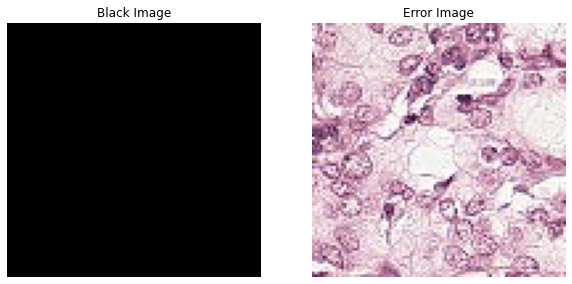

In [9]:
# Read in data in pandas data frame
df = pd.read_csv('./data/train_labels.csv', dtype=str)

"""Here I am dropping two images that caused me issues later in this project. 
One is fully black, and the other would cause an error in my model"""

# Showing the two images I will be removing 
fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].imshow(Image.open('./data/train/9369c7278ec8bcc6c880d99194de09fc2bd4efbe.tif'))
axes[1].imshow(Image.open('./data/train/dd6dfed324f9fcb6f93f46f32fc800f2ec196be2.tif'))
axes[0].axis('off')
axes[0].set_title("Black Image")

axes[1].axis('off')
axes[1].set_title("Error Image");

In [10]:
# Removing images from data frame
df[df['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']
df[df['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

# I also want to add .tif to the ID to match the image file names
df.id = df.id + ".tif"
print(df.head())

print(df.shape)

                                             id label
0  f38a6374c348f90b587e046aac6079959adf3835.tif     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif     1
2  755db6279dae599ebb4d39a9123cce439965282d.tif     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif     0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif     0
(220025, 2)


Before continuing on with the data cleaning I will quickly display the first 5 samples of a cancerous image and non-cancerous image. This way we can visually see the types of images we will be training on.

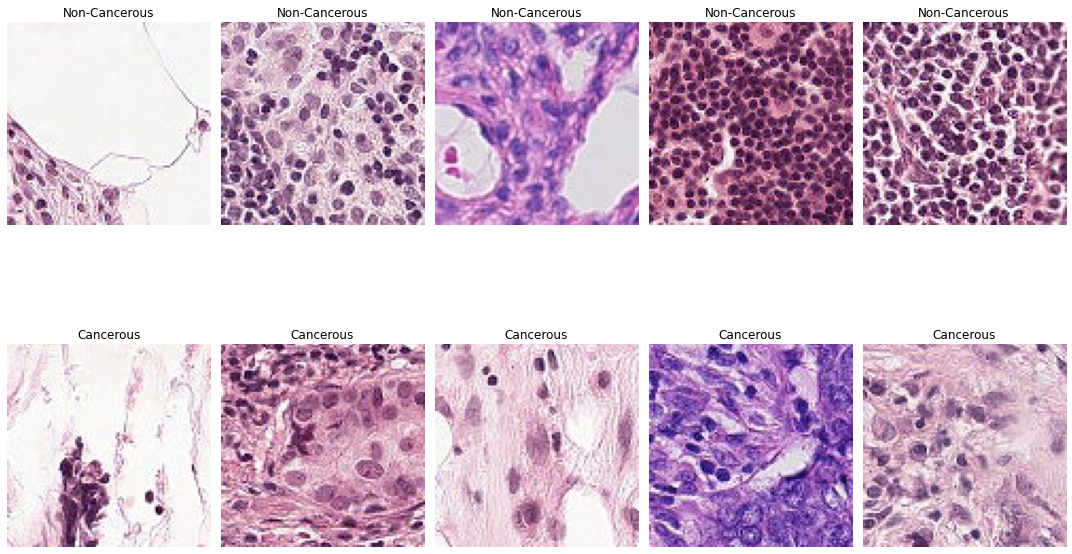

In [11]:
# Writing a simple script to get the first 5 images of a type of label
# Get a list of the labels
label_values = df.label.values
id_values = df.id.values

def get_first_five(label):
    images = []
    i = 0
    while len(images) < 5:
        if int(label_values[i]) == int(label):
            images.append(id_values[i])
        
        i += 1
        
    return images

# Now get both cancerous and non cancerous images
non_cancerous = get_first_five(0)
cancerous = get_first_five(1)
images_labels = ["Non-Cancerous", "Cancerous"]

# Display the images
fig, axes = plt.subplots(2, 5, figsize=(15,15))

for i in range(2):
    for j in range(5):
        # Make the first row non cancer and second row cancer
        if i == 0:
            images = non_cancerous
        else:
            images = cancerous
            
        # plot images with labels and remove axis
        axes[i, j].imshow(Image.open(f'./data/train/{images[j]}'))
        axes[i, j].set_title(images_labels[i])
        axes[i, j].axis('off')
        
        plt.tight_layout()

Now that we know our csv files containt no NULL values and that our images are ready; let's check the data distribution between the two categories in the label data. As mentioned above, we want to make sure they are evenly distributed.

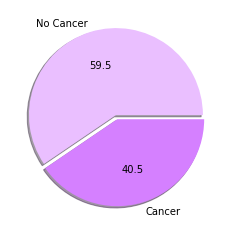

Non Cancerous Images: 130908
Cancerous Images: 89117


In [12]:
plt.pie(df['label'].value_counts(), labels=['No Cancer', 'Cancer'], 
        explode=(0,0.05), shadow=True,
        colors=['#eabfff', '#d580ff'] ,autopct='%1.1f')
plt.show()

values = df['label'].value_counts()
print(f"Non Cancerous Images: {values[0]}")
print(f"Cancerous Images: {values[1]}")

We can see from above that the training images are not even (unbalanced). There is nearly a 60/40 difference between the two types of images. To avoid any issues while training I will only take 85000 from both types of labels. This way we will ensure it's an even 50/50 between the image types.

In [13]:
non_cancer_df = df[df['label'] == '0'].sample(85000, random_state=32)
cancer_df = df[df['label'] == '1'].sample(85000, random_state=32)

new_df = shuffle(pd.concat([non_cancer_df, cancer_df], axis=0).reset_index(drop=True))

values = new_df['label'].value_counts()
print(f"Non Cancerous Images: {values[0]}")
print(f"Cancerous Images: {values[1]}")

Non Cancerous Images: 85000
Cancerous Images: 85000


Now that we have the even 50/50 labels in our data we can begin prepping our model. To do this we first want to split our training data into training and validation groups. "Split arrays or matrices into random train and test subsets."


Ref: 
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [14]:
from sklearn.model_selection import train_test_split

# Splitting the new_df into training and validation subsets
train_df, validation_df = train_test_split(new_df, test_size=0.2, random_state=1, stratify=new_df.label)

# Display the shape of our new data frames
print(train_df.shape)
print(validation_df.shape)

# Lets see the amount of images in each
print(train_df['label'].value_counts())
print(validation_df['label'].value_counts())

print(train_df.head())

(136000, 2)
(34000, 2)
0    68000
1    68000
Name: label, dtype: int64
1    17000
0    17000
Name: label, dtype: int64
                                                  id label
38033   1827890a386291fc65ac561178e770bce30d90e2.tif     0
88414   cb76b05073dc8558352ab37bdce34c1ae408b094.tif     1
161484  eba2e3c3c92c9021784cf97c75a11777cf5ceabb.tif     1
47491   8038b66a3a4c862f74e3405444e808364b67efe1.tif     0
50981   8e11d480448fea69756e48d7b0a174dac5d171be.tif     0


Now I can start creating the models. But first I want to adjust the images slightly. Plus we need to run our models on small batch sizes as mentioned in Kaggle. The perfect way to do this is using the ImageDataGenerator function in keras. "Generate batches of tensor image data with real-time data augmentation." I can alter the image a ton with this function, however to keep things simple I only want to convert the pixel values from integers between 0 and 255 to floats between 0 and 1 (as mentioned in the handout).

I am unsure what is a "good" batch size with this amount of data, so I'm going to use 50 for now and adjust if needed.

Ref: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory


Note: Can't tell if binary or categorical makes a difference in the class_mode parameter... <br>
"If class_mode is "categorical" (default value) it must include the y_col column with the class/es of each image. Values in column can be string/list/tuple if a single class or list/tuple if multiple classes."

In [56]:
from keras.preprocessing.image import ImageDataGenerator

train_path = "./data/train"

# Following api guide 
datagen = ImageDataGenerator(rescale=1/255)

train_batch = datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_path,
    batch_size = 50,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96),
    x_col = 'id',
    y_col = 'label',
)

valid_batch = datagen.flow_from_dataframe(
    dataframe = validation_df,
    directory = train_path,
    batch_size = 50,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96),
    x_col = 'id',
    y_col = 'label',
)

Found 136000 validated image filenames belonging to 2 classes.
Found 34000 validated image filenames belonging to 2 classes.


In [16]:
TR_STEPS = len(train_batch)
VA_STEPS = len(valid_batch)

print(TR_STEPS)
print(VA_STEPS)

2720
680


Now to build the model with it's layers. A few things to keep in mind when creating this. I liked the structure this person used in their notebook: https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb/notebook

Their model was: <br>
In <br>
[Conv2D*3 -> MaxPool2D -> Dropout] x3 --> (filters = 16, 32, 64)
Flatten <br>
Dense (256) <br>
Dropout <br>
Out <br>

The model is a little too intense for me to fully understand. So mine has a lot less layers, but this structure of Conv2d Drop Dense has worked the best for me. However, I did add a few other layers that helped my results! 

1. Our image sizes are 96 by 96. However, we "must predict a probability that center 32x32px region of a patch contains at least one pixel of tumor tissue". So we can start out with a Cropping2D layer to do this.

2. Next we can use a Conv2D "convolution kernel that is convolved with the layer input to produce a tensor of outputs."
https://keras.io/api/layers/convolution_layers/convolution2d/

3. I thought since this was a classification problem we would've used a sigmoid activation function. But after doing research I can see that the 'relu' function provides the best results. I also added a softmax activation function at the bottom of my model which "Softmax converts a vector of values to a probability distribution.The elements of the output vector are in range (0, 1) and sum to 1."
https://keras.io/api/layers/activations/











In [36]:
from keras import Sequential
from keras.layers import *

np.random.seed(1)
tf.random.set_seed(1)

model = Sequential([
    Cropping2D(cropping=((32, 32), (32, 32)), input_shape=(96,96,3)),
    Conv2D(16, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(16, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),

    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),

    Flatten(),
    
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cropping2d_4 (Cropping2D)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 16, 16, 16)        0         
                                                                 
 batch_normalization_11 (Bat  (None, 16, 16, 16)       64        
 chNormalization)                                     

In [37]:
opt = tf.keras.optimizers.Adam(0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [38]:
fit_model = model.fit(
    x = train_batch, 
    steps_per_epoch = TR_STEPS, 
    epochs = 5,
    validation_data = valid_batch, 
    validation_steps = VA_STEPS, 
    verbose = 1
)

Epoch 1/5
2720/2720 [==============================] - 97s 35ms/step - loss: 0.5806 - accuracy: 0.7200 - val_loss: 0.6348 - val_accuracy: 0.6314
Epoch 2/5
2720/2720 [==============================] - 96s 35ms/step - loss: 0.5255 - accuracy: 0.7579 - val_loss: 0.4994 - val_accuracy: 0.7641
Epoch 3/5
2720/2720 [==============================] - 92s 34ms/step - loss: 0.5183 - accuracy: 0.7622 - val_loss: 0.5711 - val_accuracy: 0.7502
Epoch 4/5
2720/2720 [==============================] - 92s 34ms/step - loss: 0.5099 - accuracy: 0.7691 - val_loss: 0.5601 - val_accuracy: 0.7192
Epoch 5/5
2720/2720 [==============================] - 91s 34ms/step - loss: 0.5030 - accuracy: 0.7735 - val_loss: 0.4753 - val_accuracy: 0.7862


In [39]:
history = fit_model.history
print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


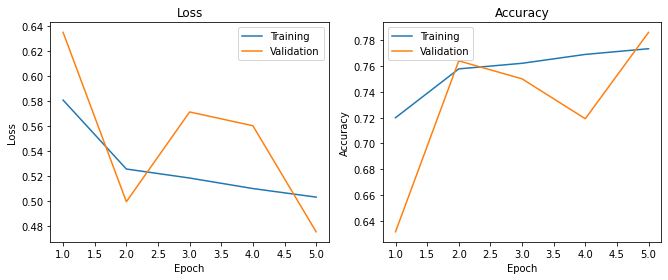

In [53]:
epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,3,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()


plt.subplot(1,3,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();

This was one of the best models I could produce. With a final accuracy of 0.7735 and a lose of about 0.5030. I'm sure there are things I could to do improve my model. Such as extra layers. I think adding another Conv2D(128) layer could help. I wish I had more time to run this with a higher Epoch number. Overall I am happy with the 0.77 result for my first attempt at making a model. The keras library was confusing for me to use but I slowly got the hang of it. Below is simply setting up my submission files.

### Submission

In [60]:
test = pd.read_csv('./data/sample_submission.csv')
test['filename'] = test.id + '.tif'
print('Test Set Size:', test.shape)
test.head()

Test Set Size: (57458, 3)


,id,label,filename
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif
1,95596b92e5066c5c52466c90b69ff089b39f2737,0,95596b92e5066c5c52466c90b69ff089b39f2737.tif
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif
3,2c35657e312966e9294eac6841726ff3a748febf,0,2c35657e312966e9294eac6841726ff3a748febf.tif
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif


In [74]:
test_path = "./data/test"
print('Test Images:', len(os.listdir(test_path)))

Test Images: 57458


In [75]:
BATCH_SIZE = 64

test_datagen = ImageDataGenerator(rescale=1/255)

test_loader = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = test_path,
    x_col = 'filename',
    batch_size = BATCH_SIZE,
    shuffle = False,
    class_mode = None,
    target_size = (96,96)
)

test_probs = model.predict(test_loader)
print(test_probs.shape)
print(len(test_loader))
print(test_probs[:10,].round(2))
test_pred = np.argmax(test_probs, axis=1)
print(test_pred[:10])

Found 57458 validated image filenames.
(57458, 2)
898
[[0.79 0.21]
 [0.43 0.57]
 [0.76 0.24]
 [0.65 0.35]
 [0.5  0.5 ]
 [0.7  0.3 ]
 [0.01 0.99]
 [0.11 0.89]
 [0.36 0.64]
 [0.01 0.99]]
[0 1 0 0 0 0 1 1 1 1]


In [76]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [77]:
submission.label = test_probs[:,1]
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.205375
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.572540
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.241219
3,2c35657e312966e9294eac6841726ff3a748febf,0.351908
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.496643


In [78]:
submission.to_csv('submission.csv', header=True, index=False)